In [546]:
!pip install pandas matplotlib seaborn phik imblearn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [547]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from phik.report import plot_correlation_matrix
import numpy as np
from scipy.stats import shapiro
import math

# загружаем класс pipeline
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion

# загружаем классы для подготовки данных
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import f1_score, mean_absolute_error, classification_report

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

import warnings

In [548]:
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

### Тренировочная выборка

In [549]:
df_train = pd.read_csv('datasets/kaggle_startups_train_01.csv')
df_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,"828,626.00",operating,CHE,25,Zurich,Zürich,2,2010-06-24,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,"42,935,019.00",operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,"35,456,381.00",operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,"22,250,000.00",operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-07-30,2012-02-01,2012-02-01,NaN
5,Connected Sports Ventures,Mobile,"4,300,000.00",operating,USA,NJ,Newark,Princeton,1,2011-04-21,2012-11-12,2012-11-12,NaN
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,"90,000,000.00",operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,NaN
7,Mesh Networks,Software,"4,300,000.00",operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,NaN
8,AngioScore,Biotechnology,"42,000,000.00",operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,NaN
9,Vidatronic,Semiconductors,"1,250,500.00",operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,NaN


In [550]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52878 non-null  object 
 1   category_list      50374 non-null  object 
 2   funding_total_usd  42753 non-null  float64
 3   status             52879 non-null  object 
 4   country_code       47351 non-null  object 
 5   state_code         46082 non-null  object 
 6   region             46489 non-null  object 
 7   city               46489 non-null  object 
 8   funding_rounds     52879 non-null  int64  
 9   founded_at         52879 non-null  object 
 10  first_funding_at   52858 non-null  object 
 11  last_funding_at    52879 non-null  object 
 12  closed_at          4962 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Описание колонок:
 
- `name` — наименование компании;
- `category_list` — категории деятельности компании;
- `funding_total_usd` — сумма привлечённых инвестиций в долларах;
- `status` — статус компании;
- `country_code` — код страны;
- `state_code` — код штата;
- `region` — регион;
- `city` — город;
- `funding_rounds` — число раундов, в которых компания привлекала инвестиции;
- `founded_at` — дата основания фонда;
- `first_funding_at` — дата первого финансирования;
- `last_funding_at` — дата последнего финансирования;
- `closed_at` — дата закрытия;

Наименование колонок корректное, у некоторых колонок не соответствуют типы.


### Тестовая выборка

In [551]:
df_test = pd.read_csv('datasets/kaggle_startups_test_01.csv')
df_test.head(10)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Crystalsol,Clean Technology,"2,819,200.00",NIC,17,NaN,NaN,1,2008-06-01,2009-07-01,2009-07-01,NaN
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-25,2010-07-28,2010-07-28,NaN
2,COINPLUS,Finance,"428,257.00",LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-06-16,2014-05-15,2014-09-18,NaN
3,Imagine Communications,Software|Video|Video Streaming,"34,700,000.00",USA,CA,San Diego,San Diego,4,2005-01-01,2005-01-01,2010-04-20,NaN
4,DNA13,Software,"4,530,000.00",CAN,ON,Ottawa,Ottawa,1,2001-01-01,2007-05-08,2007-05-08,NaN
5,Quickfire Games,Design|Entertainment|Games,"160,000.00",NaN,NaN,NaN,NaN,2,2013-09-01,2013-09-18,2014-09-18,NaN
6,Sente Inc.,Biotechnology,"26,842,000.00",USA,CA,San Diego,Encinitas,5,2007-01-01,2009-01-31,2014-06-02,NaN
7,Triosyn,Health Care|Medical|Therapeutics,"4,000,000.00",NaN,NaN,NaN,NaN,1,2001-12-26,2003-06-02,2003-06-02,NaN
8,Urgent.ly,Software,"8,710,000.00",USA,VA,"Washington, D.C.",Sterling,3,2013-01-01,2014-04-17,2015-09-29,NaN
9,Map Decisions,Software,"13,200.00",USA,PA,Allentown,Bethlehem,1,2012-05-15,2013-08-09,2013-08-09,NaN


In [552]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13211 non-null  object 
 1   category_list      12610 non-null  object 
 2   funding_total_usd  10616 non-null  float64
 3   country_code       11827 non-null  object 
 4   state_code         11512 non-null  object 
 5   region             11618 non-null  object 
 6   city               11620 non-null  object 
 7   funding_rounds     13211 non-null  int64  
 8   founded_at         13211 non-null  object 
 9   first_funding_at   13211 non-null  object 
 10  last_funding_at    13211 non-null  object 
 11  closed_at          1234 non-null   object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.2+ MB


Описание колонок:
 
- `name` — наименование компании;
- `category_list` — категории деятельности компании;
- `funding_total_usd` — сумма привлечённых инвестиций в долларах;
- `country_code` — код страны;
- `state_code` — код штата;
- `region` — регион;
- `city` — город;
- `funding_rounds` — число раундов, в которых компания привлекала инвестиции;
- `founded_at` — дата основания фонда;
- `first_funding_at` — дата первого финансирования;
- `last_funding_at` — дата последнего финансирования;
- `closed_at` — дата закрытия;

Наименование колонок корректное, у колонок с датами не соответствуют типы.

## Предобработка данных

Вспомогательные функции

In [553]:
# Определим имена колонок для отображения
column_names = {
    "name": "наименование компании",
    "category_list": "категории деятельности компании",
    "funding_total_usd": "сумма привлечённых инвестиций в долларах",
    "country_code": "код страны",
    "state_code": "код штата",
    "region": "регион",
    "city": "город",
    "funding_rounds": "число раундов, в которых компания привлекала инвестиции",
    "founded_at": "дата основания фонда",
    "first_funding_at": "дата первого финансирования",
    "last_funding_at": "дата последнего финансирования",
    "closed_at": "дата закрытия",
    "status": "статус компании",
    "category": "статус компании"
}

In [554]:
# Функция для обработки пропусков
def isna_rate(df):
    df_isna = (pd.DataFrame(round(df.isna().mean() * 100, 2)).sort_values(by=0, ascending=False))
    df_isna.columns = ['Доля_пропусков']
    df_isna['Кол-во_пропусков'] = df.isna().sum()
    df_isna['Всего_записей'] = df.shape[0]
    display(df_isna.query('Доля_пропусков > 0'))

In [555]:
# Функция для обработки строковых колонок
def check_unique(df):
    for column in df.select_dtypes(include='object').columns.tolist():
        print(f"Колонка \"{column}\":")
        print(df[column].value_counts(), "\n")

In [556]:
# Проверяет на дубликаты
def check_duplicated(df):
    dupl = df.duplicated().sum()
    print("Количество дубликатов:", dupl)
    if dupl > 0:
        display(df[df.duplicated()])
    else:
        print("Дубликаты отсутствуют")

### Тренировочная выборка

#### Типы

Приведем типы с датами в верный формат

In [557]:
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'])
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])
df_train['closed_at'] = pd.to_datetime(df_train['closed_at'])

Приведем типы со статусом к 0 / 1

In [558]:
# Функция для подсчета количества категорий
def status_int(row):
    if row == 'closed':
        return 1
    else:
        return 0


# Создадим новую колонку кол-во категорий
df_train['status'] = df_train['status'].apply(status_int)

In [559]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52879 entries, 0 to 52878
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52878 non-null  object        
 1   category_list      50374 non-null  object        
 2   funding_total_usd  42753 non-null  float64       
 3   status             52879 non-null  int64         
 4   country_code       47351 non-null  object        
 5   state_code         46082 non-null  object        
 6   region             46489 non-null  object        
 7   city               46489 non-null  object        
 8   funding_rounds     52879 non-null  int64         
 9   founded_at         52879 non-null  datetime64[ns]
 10  first_funding_at   52858 non-null  datetime64[ns]
 11  last_funding_at    52879 non-null  datetime64[ns]
 12  closed_at          4962 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(2), object(6)
memory 

Добавим колонку категория и назначим ей категорию из ТОП

In [560]:
# Разделяем категории в колонке category_list по символу '|' и создаем новую колонку
df_train['categories'] = df_train['category_list'].str.split('|')

# # Создаем новый DataFrame, в котором каждая категория будет отдельной строкой
categories_df = df_train['category_list'].str.split('|').explode('categories')

# Считаем количество вхождений каждой категории
category_counts = categories_df.value_counts()

# Получаем топ категорий
top_categories = category_counts.index.tolist()

# Удалим временную колонку
df_train = df_train.drop(['categories'], axis=1)


def is_nan(value):
    try:
        return math.isnan(float(value))
    except ValueError:
        return False


# # Функция для проверки наличия категорий из топа в списке категорий
def check_top_categories(category_list):
    for top_category in top_categories:
        if is_nan(category_list):
            return 'Other'
        elif top_category in category_list.split('|'):
            return top_category
        else:
            # print(category_list)
            return 'Other'


category_counts

category_list
Software               7033
Mobile                 4405
Biotechnology          3683
E-Commerce             3316
Curated Web            2417
                       ... 
Made in Italy             1
Private Corrections       1
Direct Advertising        1
Labor Optimization        1
Elderly                   1
Name: count, Length: 854, dtype: int64

In [561]:
df_train['category'] = df_train['category_list'].apply(check_top_categories)
df_train.category.unique()

array(['Other', 'Software'], dtype=object)

#### Пропуски

In [562]:
isna_rate(df_train)

,Доля_пропусков,Кол-во_пропусков,Всего_записей
closed_at,90.62,47917,52879
funding_total_usd,19.15,10126,52879
state_code,12.85,6797,52879
region,12.08,6390,52879
city,12.08,6390,52879
country_code,10.45,5528,52879
category_list,4.74,2505,52879
first_funding_at,0.04,21,52879


In [563]:
# Удалим значения с пустыми датами первого финансирования так как их 0,04%
df_train = df_train.query('~first_funding_at.isna()')

In [564]:
# Проверим данные с не заполнеными данными страна, категория, финансирование
df_train.query('country_code.isna() & category_list.isna() & funding_total_usd.isna()')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category
16,Salesjob,NaN,NaN,1,NaN,NaN,NaN,NaN,1,2013-01-01,2013-10-22,2013-10-22,2015-09-26,Other
24,Savasti,NaN,NaN,1,NaN,NaN,NaN,NaN,1,2015-01-01,2015-01-01,2015-01-01,2016-03-19,Other
65,Seamless Logistics,NaN,NaN,0,NaN,NaN,NaN,NaN,1,2009-03-26,2011-02-01,2011-02-01,NaT,Other
79,Efficient Photon,NaN,NaN,1,NaN,NaN,NaN,NaN,1,2009-11-11,2011-09-22,2011-09-22,2013-04-21,Other
156,Public Post,NaN,NaN,1,NaN,NaN,NaN,NaN,1,2007-12-08,2008-08-14,2008-08-14,2009-12-23,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52690,Connexions,NaN,NaN,0,NaN,NaN,NaN,NaN,1,2010-07-11,2012-05-01,2012-05-01,NaT,Other
52740,Maremonti,NaN,NaN,0,NaN,NaN,NaN,NaN,1,2011-09-12,2013-08-01,2013-08-01,NaT,Other
52757,Ogg Trading,NaN,NaN,0,NaN,NaN,NaN,NaN,1,2014-08-30,2015-06-01,2015-06-01,NaT,Other
52767,Beach Bum,NaN,NaN,1,NaN,NaN,NaN,NaN,1,2014-08-11,2015-05-18,2015-05-18,2017-03-22,Other


Так как такие данные содержат пустые поля во всех ключевых параметров уберем их

In [565]:
df_train = df_train.query('~(country_code.isna() & category_list.isna() & funding_total_usd.isna())')
isna_rate(df_train)

,Доля_пропусков,Кол-во_пропусков,Всего_записей
closed_at,91.05,47321,51973
funding_total_usd,17.78,9240,51973
state_code,11.37,5910,51973
region,10.59,5503,51973
city,10.59,5503,51973
country_code,8.93,4641,51973
category_list,3.12,1619,51973


Заполнение пустых полей в колонке funding_total_usd средним значением по соответствующим state_code и country_code

In [566]:
def set_funding_total_usd_mean(df):
    # Группируем по country_code и state_code и вычисляем среднее значение funding_total_usd
    df['funding_total_usd_mean'] = df.groupby(['country_code', 'state_code', 'category'])[
        'funding_total_usd'].transform('mean')

    # Заполняем пустые значения в funding_total_usd средними значениями из funding_total_usd_mean
    df['funding_total_usd'].fillna(df['funding_total_usd_mean'], inplace=True)

    # Удаляем временную колонку funding_total_usd_mean
    df.drop('funding_total_usd_mean', axis=1, inplace=True)

In [567]:
set_funding_total_usd_mean(df_train)
isna_rate(df_train)

,Доля_пропусков,Кол-во_пропусков,Всего_записей
closed_at,91.05,47321,51973
state_code,11.37,5910,51973
region,10.59,5503,51973
city,10.59,5503,51973
country_code,8.93,4641,51973
category_list,3.12,1619,51973
funding_total_usd,2.52,1310,51973


#### Неявные дубликаты

In [568]:
check_unique(df_train)

Колонка "name":
name
Lunchgate             1
Milaap                1
Mabaya                1
CyberCity 3D, Inc.    1
Advanced Media        1
                     ..
Insignia Health       1
Repair Report         1
Protagen              1
HistoryFile           1
Apparcando            1
Name: count, Length: 51972, dtype: int64 

Колонка "category_list":
category_list
Software                                                                                  3215
Biotechnology                                                                             2916
E-Commerce                                                                                1067
Mobile                                                                                     921
Clean Technology                                                                           896
                                                                                          ... 
Communities|Hunting Industry|Outdoors|Sports                   

#### Явные дубликаты

In [569]:
check_duplicated(df_train)

Количество дубликатов: 0
Дубликаты отсутствуют


### Тестовая выборка

#### Типы

Приведем типы с датами в верный формат

In [570]:
df_test['founded_at'] = pd.to_datetime(df_train['founded_at'])
df_test['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_test['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])
df_test['closed_at'] = pd.to_datetime(df_train['closed_at'])

Добавим колонку категория и назначим ей категорию из ТОП

In [571]:
df_test['category'] = df_test['category_list'].apply(check_top_categories)
df_test.category.unique()

array(['Other', 'Software'], dtype=object)

#### Пропуски

In [572]:
isna_rate(df_test)

,Доля_пропусков,Кол-во_пропусков,Всего_записей
closed_at,90.95,12016,13211
funding_total_usd,19.64,2595,13211
state_code,12.86,1699,13211
region,12.06,1593,13211
city,12.04,1591,13211
country_code,10.48,1384,13211
category_list,4.55,601,13211
founded_at,1.72,227,13211
first_funding_at,1.72,227,13211
last_funding_at,1.72,227,13211


In [573]:
# Проверим данные с не заполнеными данными страна, категория, финансирование
df_test.query('country_code.isna() & category_list.isna() & funding_total_usd.isna()')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category
81,Indie Broadcast Network,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-06-14,2011-07-01,2014-10-30,NaT,Other
188,Desafío Táctico,NaN,NaN,NaN,NaN,NaN,NaN,1,2002-02-02,2013-08-28,2013-08-28,NaT,Other
233,Nemo,NaN,NaN,NaN,NaN,NaN,NaN,1,2004-01-01,2013-09-24,2013-09-24,NaT,Other
343,LaunchCenter 39,NaN,NaN,NaN,NaN,NaN,NaN,1,2012-03-04,2012-03-04,2012-03-04,NaT,Other
363,BorderX Lab,NaN,NaN,NaN,NaN,NaN,NaN,1,2010-08-19,2011-04-01,2011-04-01,NaT,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12949,PittMoss,NaN,NaN,NaN,NaN,NaN,NaN,1,2007-01-01,2009-11-03,2009-11-03,NaT,Other
12965,UGIG,NaN,NaN,NaN,NaN,NaN,NaN,1,2012-11-28,2013-07-01,2013-07-01,NaT,Other
12976,Himily,NaN,NaN,NaN,NaN,NaN,NaN,1,2013-02-26,2015-03-09,2015-03-09,NaT,Other
13077,Maboo,NaN,NaN,NaN,NaN,NaN,NaN,1,2002-01-01,2014-09-04,2014-09-04,NaT,Other


In [574]:
set_funding_total_usd_mean(df_test)
isna_rate(df_test)

,Доля_пропусков,Кол-во_пропусков,Всего_записей
closed_at,90.95,12016,13211
state_code,12.86,1699,13211
region,12.06,1593,13211
city,12.04,1591,13211
country_code,10.48,1384,13211
funding_total_usd,4.70,621,13211
category_list,4.55,601,13211
founded_at,1.72,227,13211
first_funding_at,1.72,227,13211
last_funding_at,1.72,227,13211


Есть пропуски в нескольких колонках, обработаем им далее в пайплайне.

#### Неявные дубликаты

In [575]:
check_unique(df_train)

Колонка "name":
name
Lunchgate             1
Milaap                1
Mabaya                1
CyberCity 3D, Inc.    1
Advanced Media        1
                     ..
Insignia Health       1
Repair Report         1
Protagen              1
HistoryFile           1
Apparcando            1
Name: count, Length: 51972, dtype: int64 

Колонка "category_list":
category_list
Software                                                                                  3215
Biotechnology                                                                             2916
E-Commerce                                                                                1067
Mobile                                                                                     921
Clean Technology                                                                           896
                                                                                          ... 
Communities|Hunting Industry|Outdoors|Sports                   

#### Явные дубликаты

In [576]:
check_duplicated(df_test)

Количество дубликатов: 0
Дубликаты отсутствуют


## Исследовательский анализ данных

In [577]:
# Графики для анализа числовых колонок
def column_quantitative_info(df, column):
    desc = df[column].describe()
    print(desc)
    if df[column].dtype == 'int64':
        n_bins = (df[column].max() - df[column].min()) + 1
        if n_bins > 100:
            binwidth = None
            discrete = False
            bins = 'auto'
        else:
            bins = n_bins
            discrete = True
            binwidth = 1
    else:
        binwidth = None
        discrete = False
        bins = 'auto'
    print(discrete, bins)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    sns.histplot(data=df[column], kde=False, ax=axes[0], discrete=discrete, binwidth=binwidth, bins=bins)
    axes[0].axvline(df[column].mean(), color='red', linestyle='--', label='Mean')
    axes[0].set_title('Гистограмма распределения')
    axes[0].set_ylabel('Частота')
    axes[0].set_xlabel(column_names[column])
    sns.boxplot(data=df[column], palette='rainbow', ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    axes[1].set_ylabel('Значение')
    stats.probplot(df[column], plot=sns.mpl.pyplot, dist="norm")
    axes[2].set_title('Q-Q график')
    axes[2].set_ylabel('Квантили эмпирических данных')
    axes[2].set_xlabel('Теоретические квантили')
    plt.show()

In [578]:
# Числовые колонки
def quantitative_info(df):
    for column in df.loc[:, df.columns != 'id'].select_dtypes(include='number').columns.tolist():
        stat, p_val = shapiro(df[column])
        print(f'Колонка: \'{column}\':')
        if p_val < 0.5:
            print('Распределение: не нормальное')
        else:
            print('Распределение: нормальное')
        column_quantitative_info(df, column)

In [579]:
# Строковые колонки   
def categorical_info(df):
    for column in df.loc[:, df.columns != 'id'].select_dtypes(include='object').columns.tolist():
        print(f'Колонка: \'{column_names[column]}\':')
        print((df[column].describe()))
        df[column].value_counts().plot(title=column_names[column], autopct='%1.1f%%', kind='pie', figsize=(7, 7))
        plt.ylabel(f"Соотношение {column_names[column]}")
        plt.show()

### Тренировочная выборка

In [580]:
RANDOM_STATE = 42
# Сделаем sample_df для анализа
df_train_sample = df_train.sample(n=100, random_state=RANDOM_STATE).reset_index(drop=True)

#### Количественные колонки

Колонка: 'funding_total_usd':
Распределение: нормальное
count              98.00
mean       38,589,026.41
std       145,667,800.63
min             3,000.00
25%           500,000.00
50%         3,266,180.00
75%        13,842,571.73
max     1,000,000,000.00
Name: funding_total_usd, dtype: float64
False auto


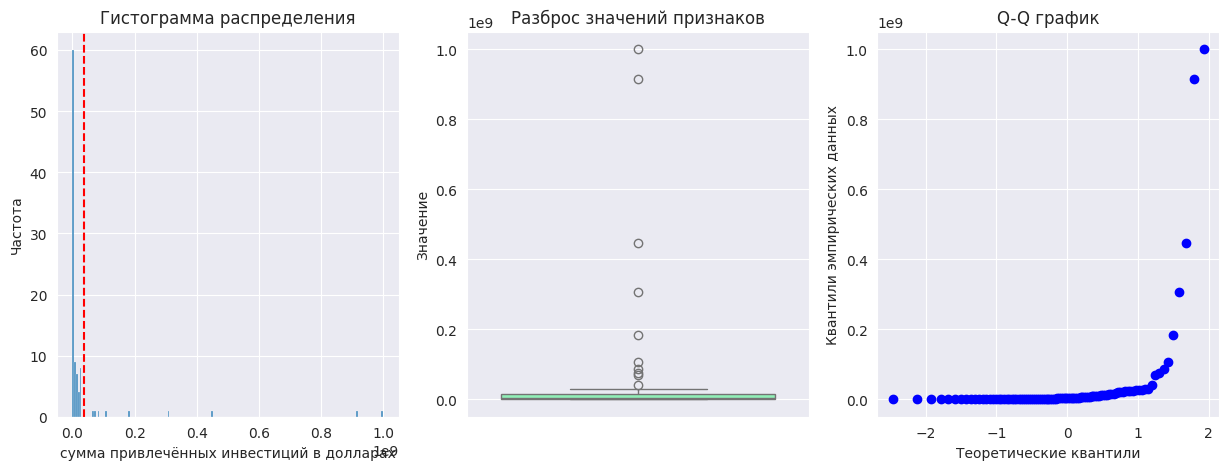

Колонка: 'status':
Распределение: не нормальное
count   100.00
mean      0.07
std       0.26
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: status, dtype: float64
True 2


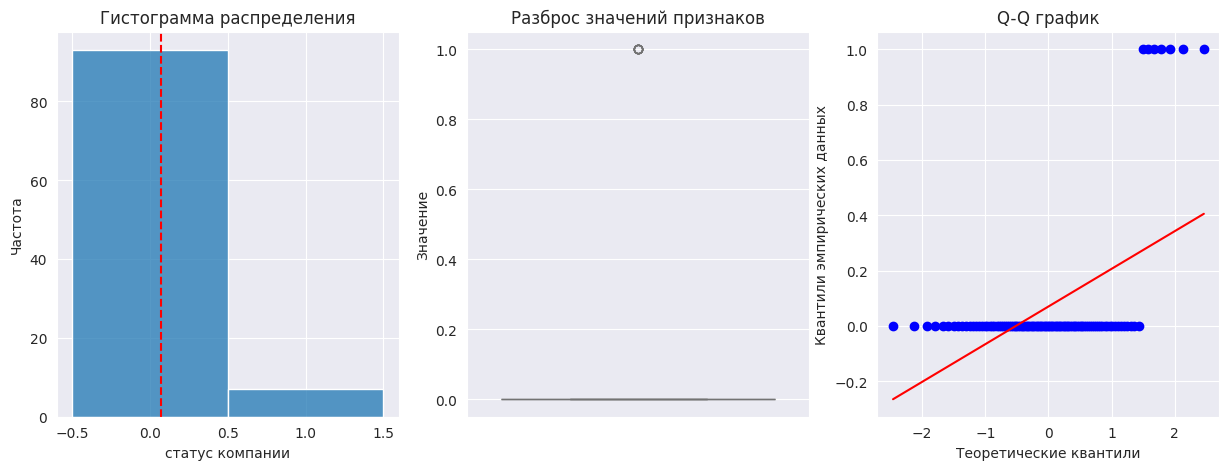

Колонка: 'funding_rounds':
Распределение: не нормальное
count   100.00
mean      2.02
std       1.66
min       1.00
25%       1.00
50%       1.00
75%       2.00
max      11.00
Name: funding_rounds, dtype: float64
True 11


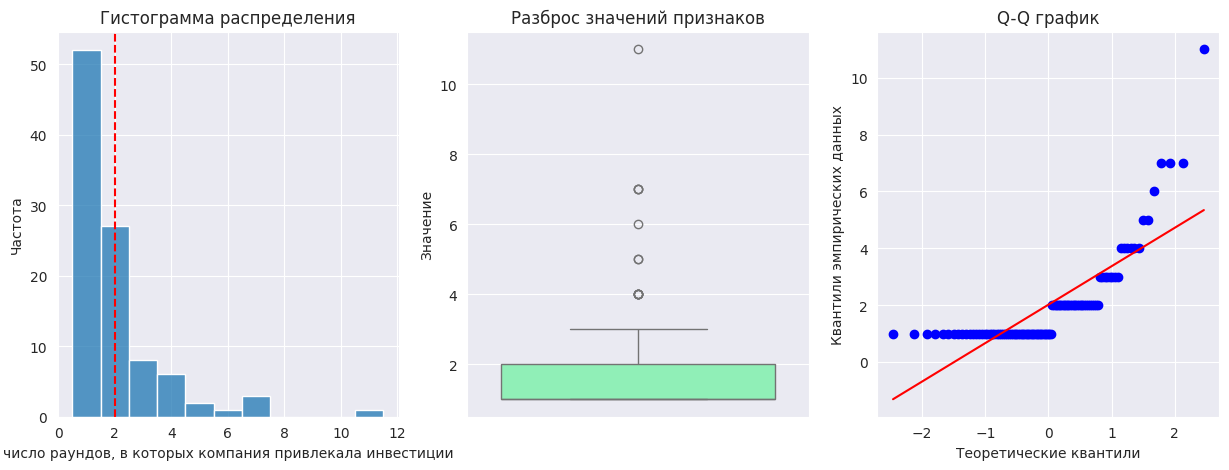

In [581]:
quantitative_info(df_train_sample)

Признаки имеют нормальное и не нормальное распределение.

Аномальных значений как таковых не выявлено.

#### Категориальные колонки

Колонка: 'код страны':
count      92
unique     19
top       USA
freq       59
Name: country_code, dtype: object


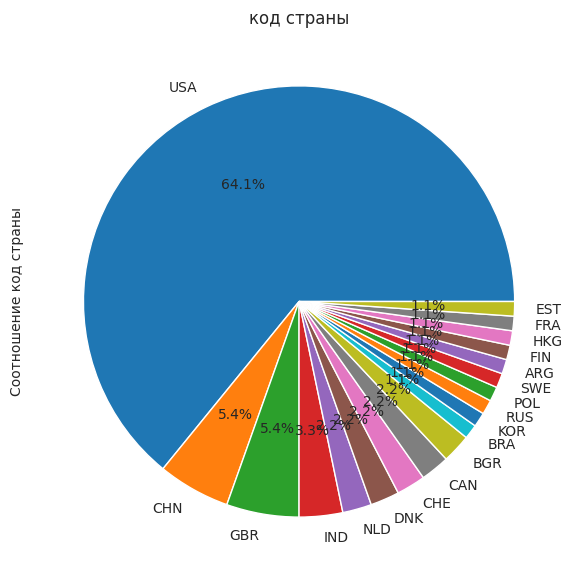

Колонка: 'код штата':
count     91
unique    40
top       CA
freq      26
Name: state_code, dtype: object


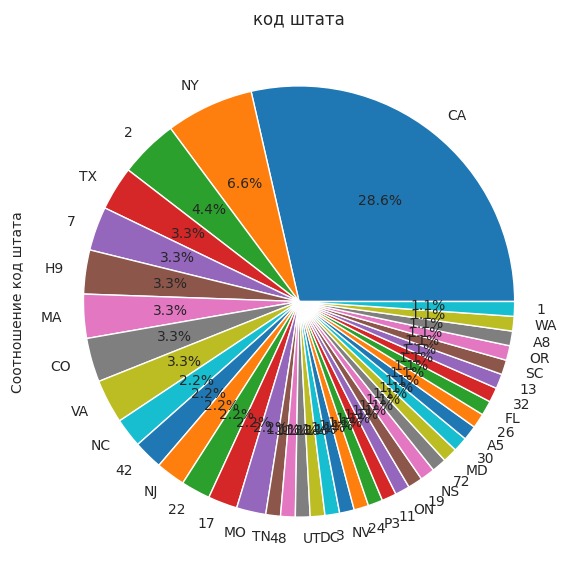

Колонка: 'регион':
count              92
unique             51
top       SF Bay Area
freq               12
Name: region, dtype: object


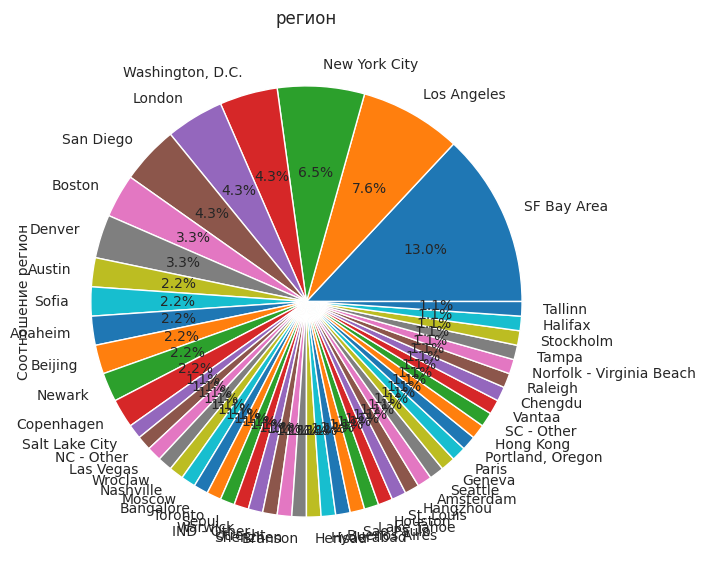

Колонка: 'город':
count                92
unique               70
top       San Francisco
freq                  7
Name: city, dtype: object


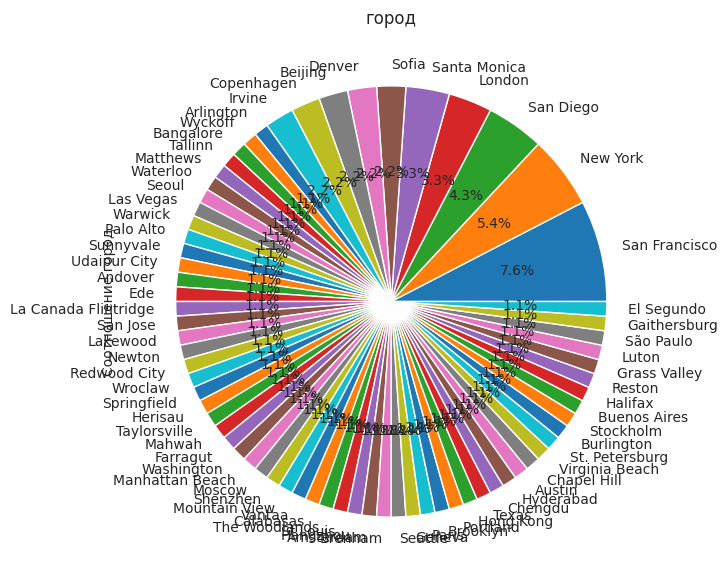

Колонка: 'статус компании':
count       100
unique        2
top       Other
freq         83
Name: category, dtype: object


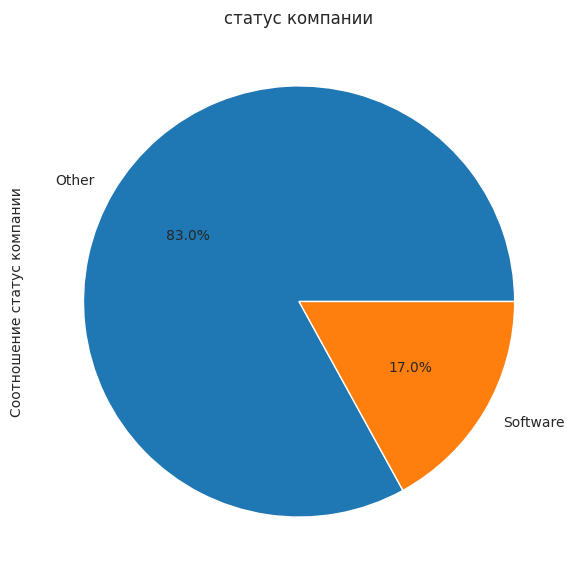

In [582]:
categorical_info(
    df_train_sample.drop(['name', 'category_list', 'closed_at', 'founded_at', 'last_funding_at', 'first_funding_at'],
                         axis=1))

Выводы:
- Популярная категория Software.
- Большинство компаний из США.
- Большинство компаний из города San Francisco.
- Большинство компаний из региона SF Bay Area.
- Большинство компаний не закрыты.

### Тестовая выборка

In [583]:
# Сделаем sample_df для анализа
df_test_sample = df_test.sample(n=100, random_state=RANDOM_STATE).reset_index(drop=True)

#### Количественные колонки

Колонка: 'funding_total_usd':
Распределение: нормальное
count            92.00
mean     21,506,683.39
std      94,587,822.65
min           5,000.00
25%         400,000.00
50%       3,130,424.75
75%      10,689,005.50
max     875,000,000.00
Name: funding_total_usd, dtype: float64
False auto


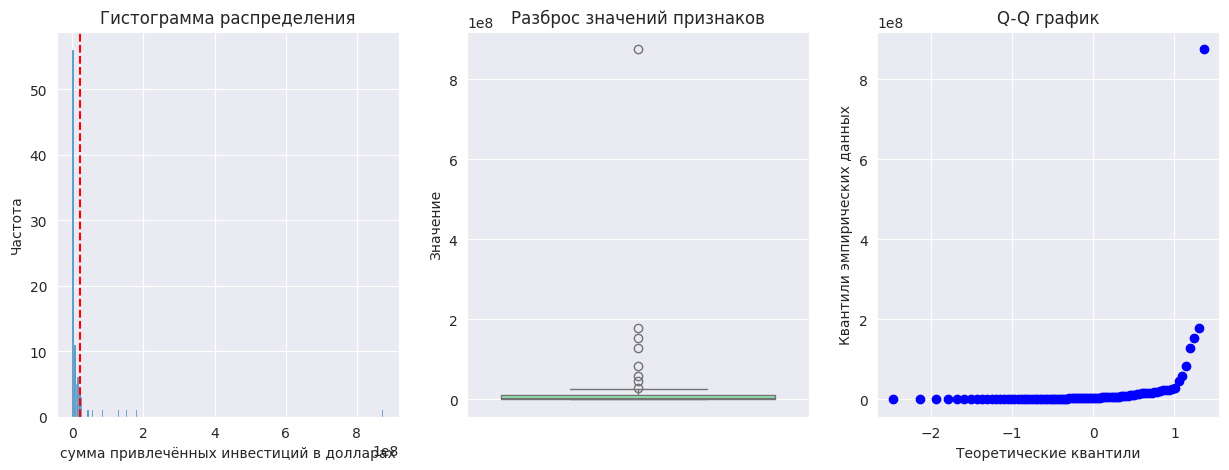

Колонка: 'funding_rounds':
Распределение: не нормальное
count   100.00
mean      1.59
std       1.09
min       1.00
25%       1.00
50%       1.00
75%       2.00
max       8.00
Name: funding_rounds, dtype: float64
True 8


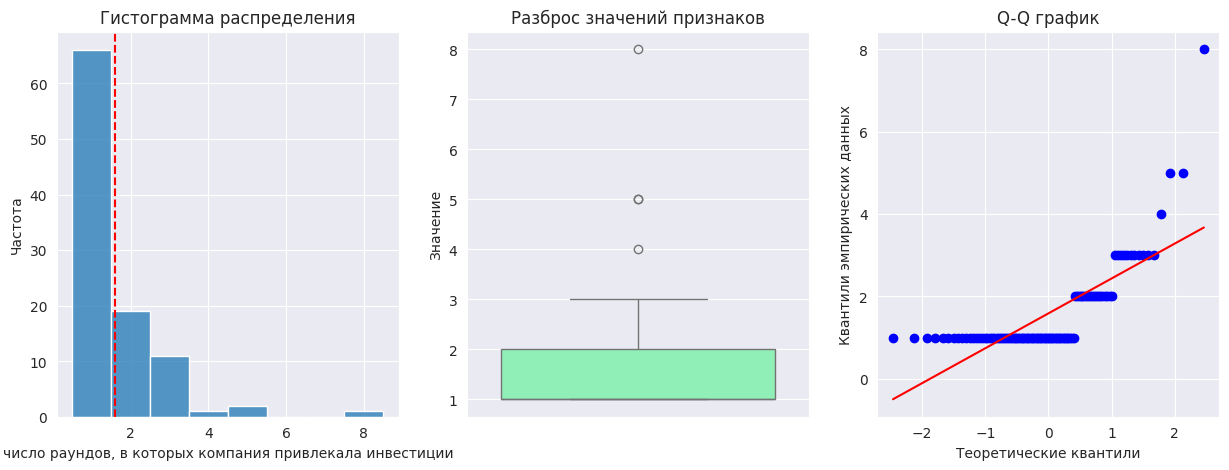

In [584]:
quantitative_info(df_test_sample)

Признаки имеют нормальное и не нормальное распределение.

Аномальных значений как таковых не выявлено.

#### Категориальные колонки

Колонка: 'код страны':
count      90
unique     17
top       USA
freq       55
Name: country_code, dtype: object


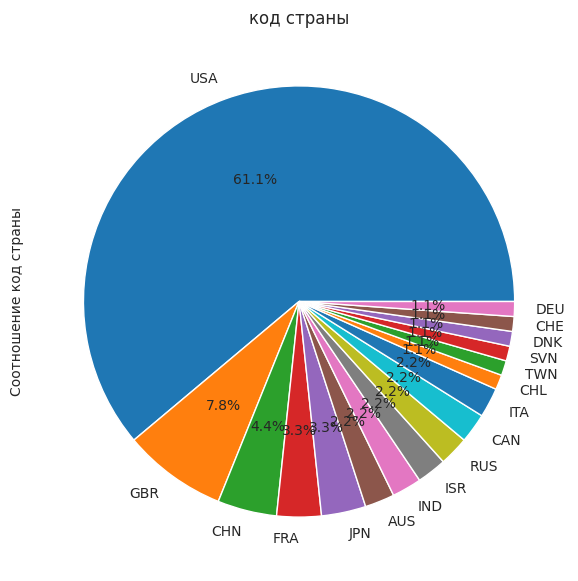

Колонка: 'код штата':
count     87
unique    43
top       CA
freq      19
Name: state_code, dtype: object


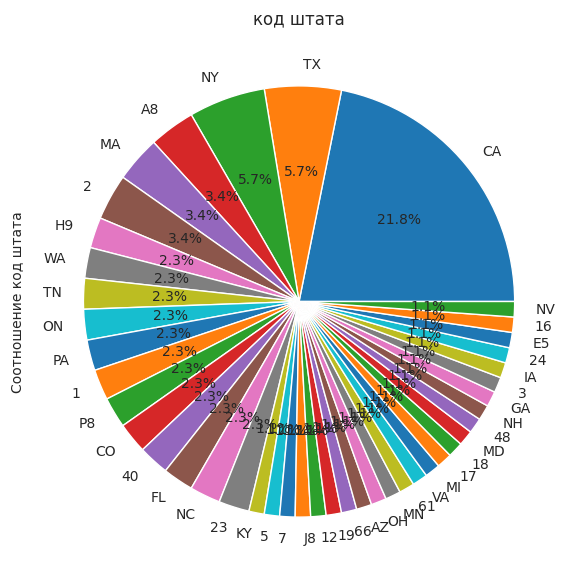

Колонка: 'регион':
count              85
unique             54
top       SF Bay Area
freq               12
Name: region, dtype: object


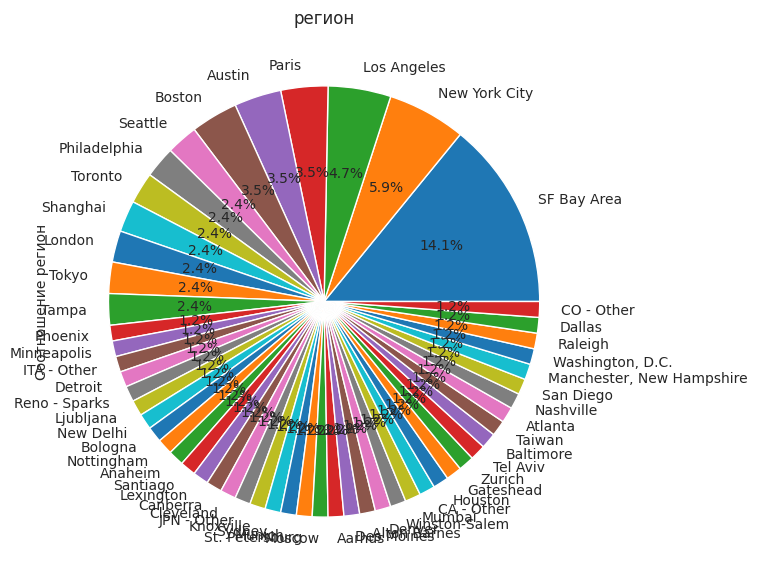

Колонка: 'город':
count           85
unique          70
top       New York
freq             4
Name: city, dtype: object


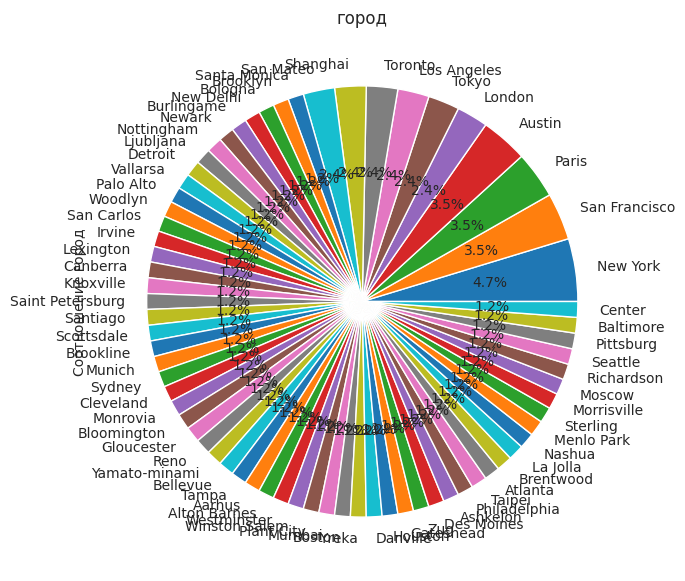

Колонка: 'статус компании':
count       100
unique        2
top       Other
freq         91
Name: category, dtype: object


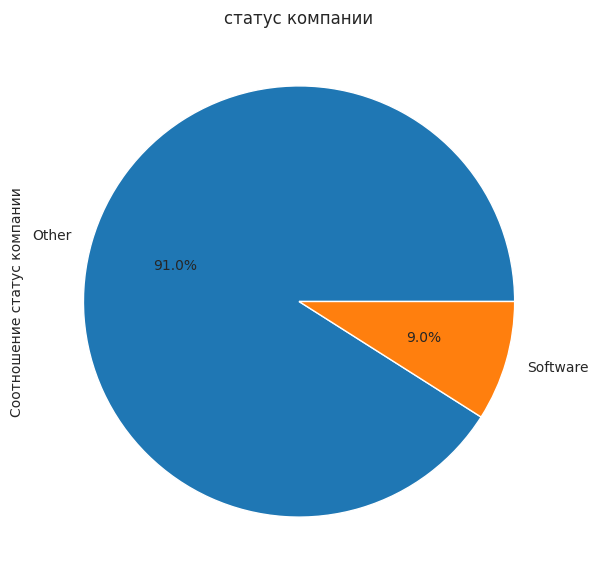

In [585]:
categorical_info(
    df_test_sample.drop(['name', 'category_list', 'closed_at', 'founded_at', 'last_funding_at', 'first_funding_at'],
                        axis=1))

Выводы:
- Популярная категория Software.
- Большинство компаний из США.
- Большинство компаний из города San Francisco.
- Большинство компаний из региона SF Bay Area.
- Статусы компании распределены почти равномерно.

## Подготовка данных

In [586]:
def show_phik_matrix(df):
    phik_overview = df.sample(1000, random_state=RANDOM_STATE).phik_matrix()
    # визуализация тепловой карты коэффициентов корреляции
    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        title=r"correlation $\phi_K$",
        fontsize_factor=1.5,
        figsize=(15, 12)
    )

### Матрица корреляции на стандартных данных

Изучим коэффициенты корреляции между всеми признаками с целью определения наличия мультиколлинеарности. Для признаков с нормальным распределением будем применять коэффициент Пирсона, а для остальных - коэффициент Спирмена.

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds']


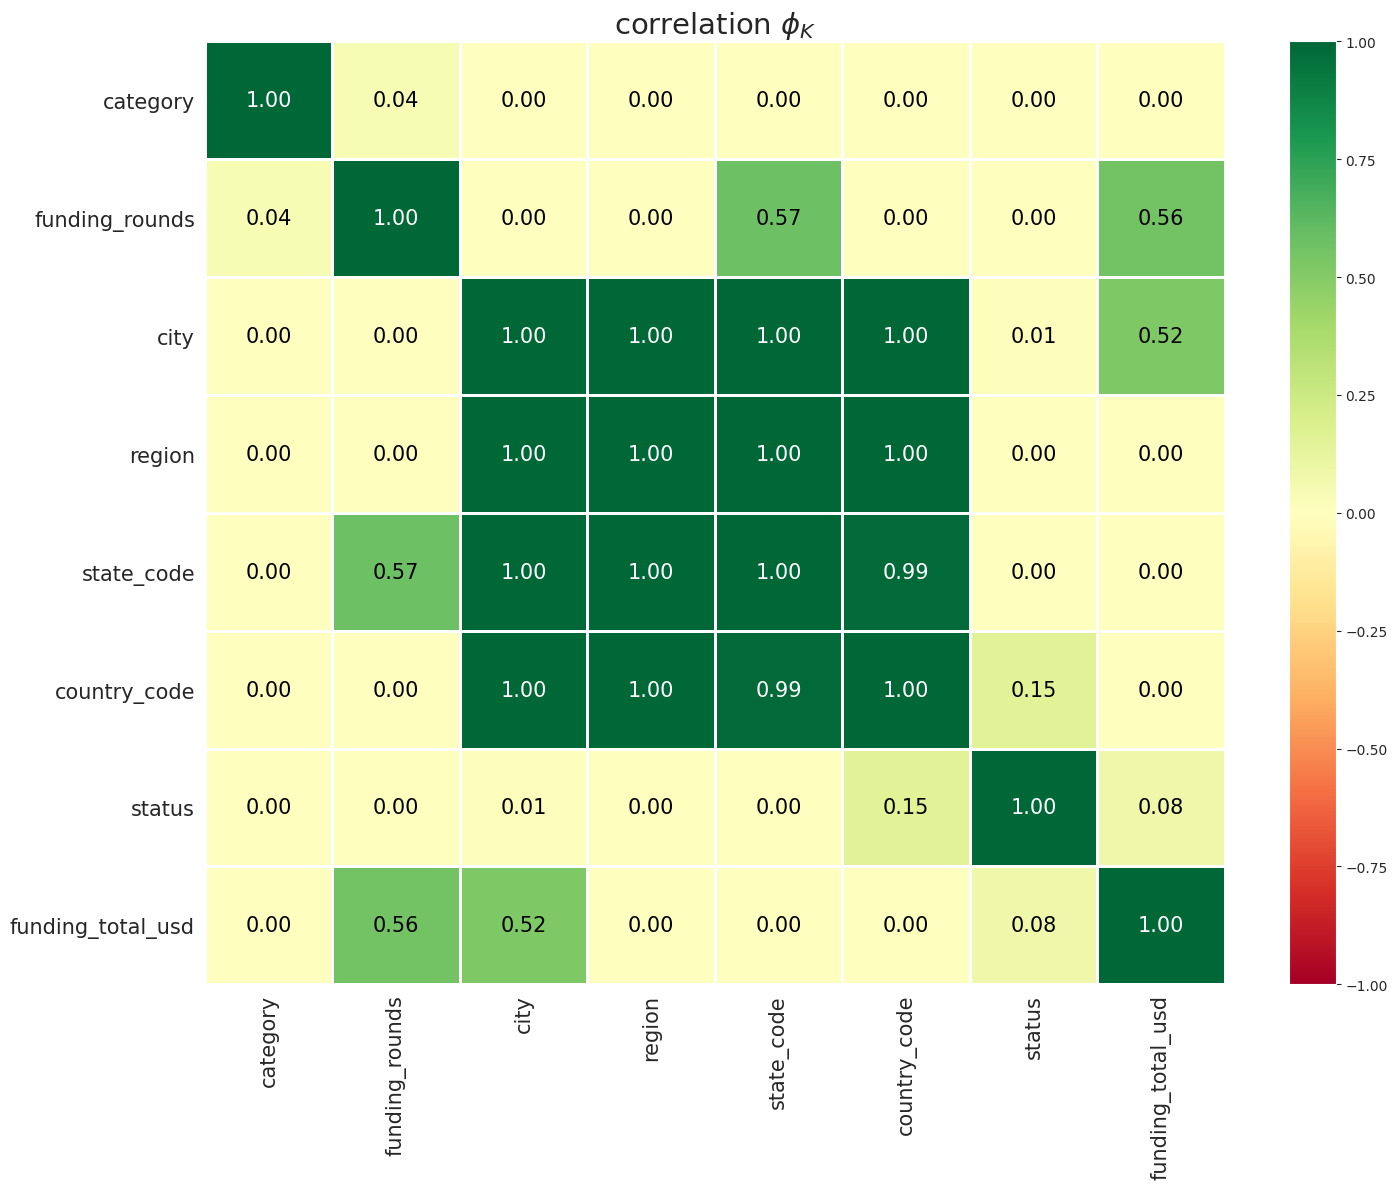

In [587]:
show_phik_matrix(
    df_train.drop(['name', 'category_list', 'closed_at', 'founded_at', 'last_funding_at', 'first_funding_at'], axis=1))

Наблюдается утечка целевого признака, по параметрам с датами закрытия

### Дополнительные колонки

#### Заполним колонки дата закрытия

In [588]:
df_train_old = df_train
# Заполним пустые значения в колонке дата закрытия на текущую дату что бы посчитать время существование компании.
# df_train.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)
df_train.closed_at = pd.to_datetime('2018-01-01')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51973 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51972 non-null  object        
 1   category_list      50354 non-null  object        
 2   funding_total_usd  50663 non-null  float64       
 3   status             51973 non-null  int64         
 4   country_code       47332 non-null  object        
 5   state_code         46063 non-null  object        
 6   region             46470 non-null  object        
 7   city               46470 non-null  object        
 8   funding_rounds     51973 non-null  int64         
 9   founded_at         51973 non-null  datetime64[ns]
 10  first_funding_at   51973 non-null  datetime64[ns]
 11  last_funding_at    51973 non-null  datetime64[ns]
 12  closed_at          51973 non-null  datetime64[ns]
 13  category           51973 non-null  object        
dtypes: datetime

In [589]:
# Проверим наличине в обучающей записей где дата закрытия меньше чем дата открытия
df_train.query('closed_at < founded_at')

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category
16845,DugoutFC Ltd,Fantasy Sports,"100,000.00",0,NaN,NaN,NaN,NaN,1,2105-02-17,2015-01-01,2015-01-01,2018-01-01,Other
48217,LIVAMP,Entertainment|Music|Video,"300,000.00",1,NaN,NaN,NaN,NaN,1,2041-09-21,2015-08-31,2015-08-31,2018-01-01,Other


In [590]:
df_train = df_train.query('closed_at >= founded_at')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51971 entries, 0 to 52878
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               51970 non-null  object        
 1   category_list      50352 non-null  object        
 2   funding_total_usd  50661 non-null  float64       
 3   status             51971 non-null  int64         
 4   country_code       47332 non-null  object        
 5   state_code         46063 non-null  object        
 6   region             46470 non-null  object        
 7   city               46470 non-null  object        
 8   funding_rounds     51971 non-null  int64         
 9   founded_at         51971 non-null  datetime64[ns]
 10  first_funding_at   51971 non-null  datetime64[ns]
 11  last_funding_at    51971 non-null  datetime64[ns]
 12  closed_at          51971 non-null  datetime64[ns]
 13  category           51971 non-null  object        
dtypes: datetime

In [591]:
df_test_old = df_test
# Заполним пустые значения в колонке дата закрытия на текущую дату что бы посчитать время существование компании.
df_test.closed_at = pd.to_datetime('2018-01-01')
# df_test.closed_at.fillna(pd.to_datetime('2018-01-01'), inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13211 non-null  object        
 1   category_list      12610 non-null  object        
 2   funding_total_usd  12590 non-null  float64       
 3   country_code       11827 non-null  object        
 4   state_code         11512 non-null  object        
 5   region             11618 non-null  object        
 6   city               11620 non-null  object        
 7   funding_rounds     13211 non-null  int64         
 8   founded_at         12984 non-null  datetime64[ns]
 9   first_funding_at   12984 non-null  datetime64[ns]
 10  last_funding_at    12984 non-null  datetime64[ns]
 11  closed_at          13211 non-null  datetime64[ns]
 12  category           13211 non-null  object        
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [592]:
# Проверим наличине в обучающей записей где дата закрытия меньше чем дата открытия
df_test.query('closed_at < founded_at')

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,category


#### Дополнительные колонки из колонок с датами

In [593]:
def create_new_columns(df):
    # Возраст компании на момент первого финансирования (first_funding_age):
    # df['age_first_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days
    df['count_usd_day_life'] = df.funding_total_usd / (df.closed_at - df.founded_at).dt.days
    df['founded_year'] = df.founded_at.dt.year
    

In [594]:
create_new_columns(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51971 entries, 0 to 52878
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                51970 non-null  object        
 1   category_list       50352 non-null  object        
 2   funding_total_usd   50661 non-null  float64       
 3   status              51971 non-null  int64         
 4   country_code        47332 non-null  object        
 5   state_code          46063 non-null  object        
 6   region              46470 non-null  object        
 7   city                46470 non-null  object        
 8   funding_rounds      51971 non-null  int64         
 9   founded_at          51971 non-null  datetime64[ns]
 10  first_funding_at    51971 non-null  datetime64[ns]
 11  last_funding_at     51971 non-null  datetime64[ns]
 12  closed_at           51971 non-null  datetime64[ns]
 13  category            51971 non-null  object        


In [595]:
create_new_columns(df_test)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13211 entries, 0 to 13210
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   name                13211 non-null  object        
 1   category_list       12610 non-null  object        
 2   funding_total_usd   12590 non-null  float64       
 3   country_code        11827 non-null  object        
 4   state_code          11512 non-null  object        
 5   region              11618 non-null  object        
 6   city                11620 non-null  object        
 7   funding_rounds      13211 non-null  int64         
 8   founded_at          12984 non-null  datetime64[ns]
 9   first_funding_at    12984 non-null  datetime64[ns]
 10  last_funding_at     12984 non-null  datetime64[ns]
 11  closed_at           13211 non-null  datetime64[ns]
 12  category            13211 non-null  object        
 13  count_usd_day_life  12377 non-null  float64   

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds', 'count_usd_day_life', 'founded_year']


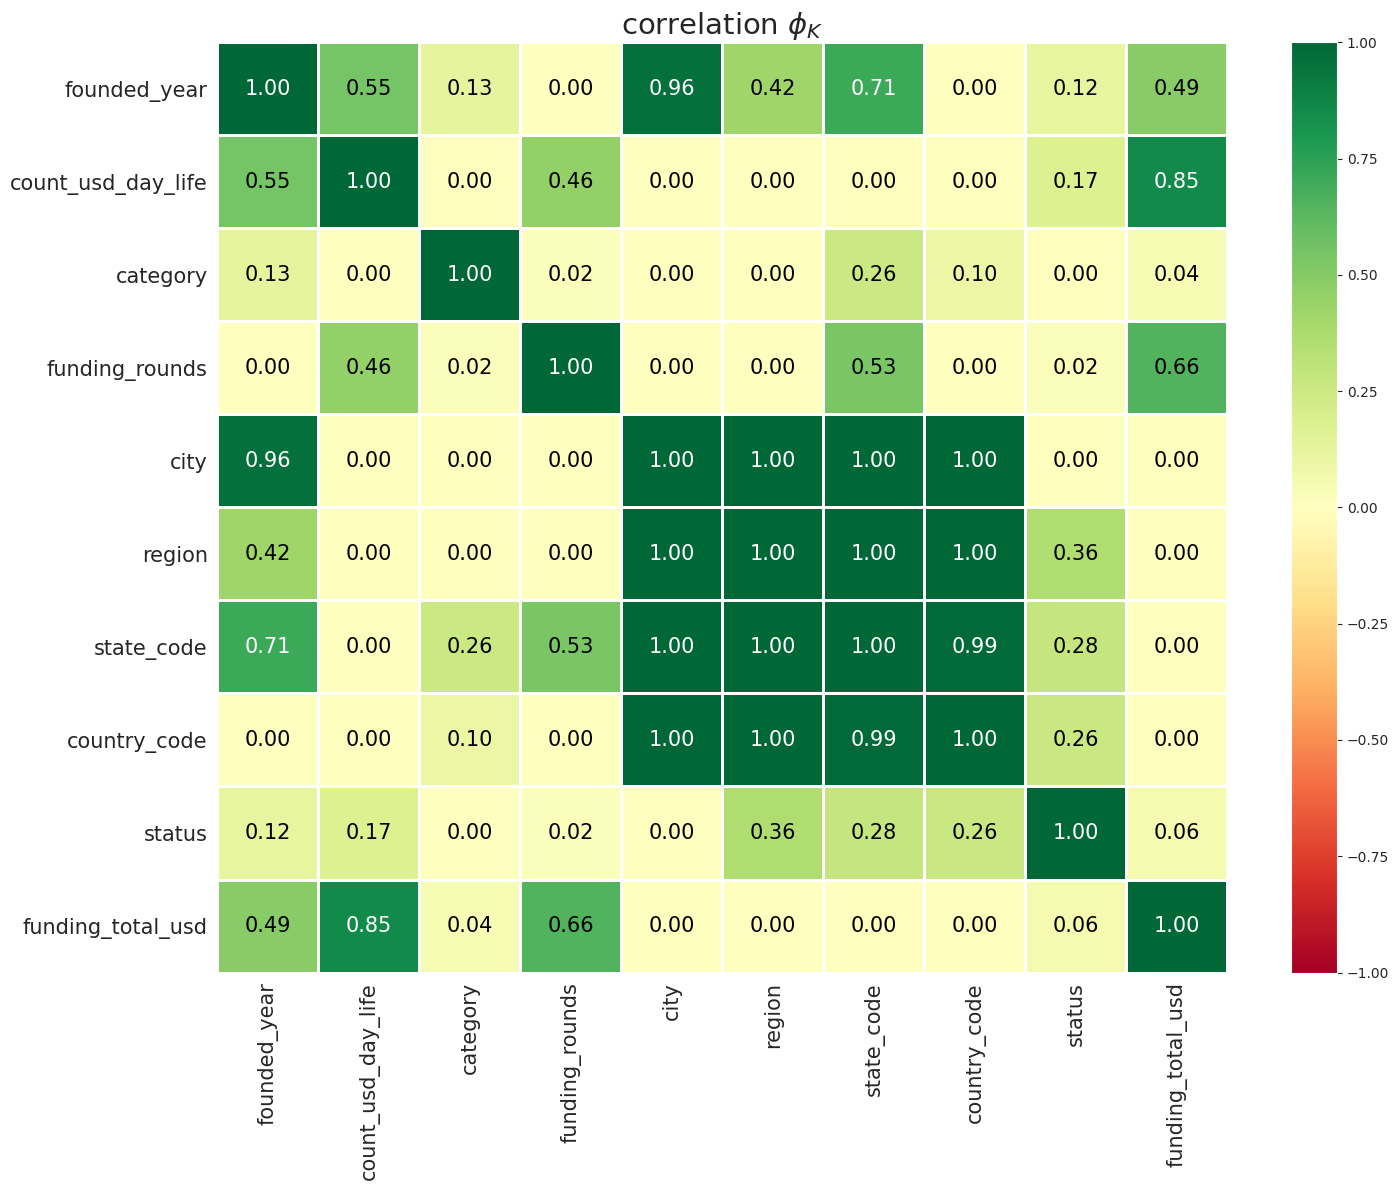

In [596]:
show_phik_matrix(df_train.drop(['name', 'category_list', 'closed_at', 'founded_at', 'last_funding_at', 'first_funding_at'], axis=1))

### Пайплайн подготовки данных

In [597]:
df_train_sample = df_train
X = df_train_sample.drop([
    'name',
    'first_funding_at',
    'last_funding_at',
    'founded_at',
    'closed_at',
    'category_list',
    'status'
], axis=1)
y = df_train_sample['status']

In [598]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51971 entries, 0 to 52878
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   funding_total_usd   50661 non-null  float64
 1   country_code        47332 non-null  object 
 2   state_code          46063 non-null  object 
 3   region              46470 non-null  object 
 4   city                46470 non-null  object 
 5   funding_rounds      51971 non-null  int64  
 6   category            51971 non-null  object 
 7   count_usd_day_life  50661 non-null  float64
 8   founded_year        51971 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(5)
memory usage: 3.8+ MB


In [611]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='most_frequent'),
    OneHotEncoder(drop='first', handle_unknown='ignore')
)

num_pipe = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'),
    StandardScaler()
)

# создаём общий пайплайн для подготовки данных
preprocessor = make_column_transformer(
    (ohe_pipe, make_column_selector(dtype_exclude='number')),
    (num_pipe, make_column_selector(dtype_include='number')),
    remainder='passthrough'
)

pipe_preparation = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('resample', SMOTE(random_state=RANDOM_STATE))
    ]
)

pipe_preparation

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd615fe4460>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd615fe4730>)])),
                ('resample', SMOTE(random_state=42))])

## Обучение модели

In [600]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
print(f'X {len(X_train)}/{len(X_test)}')
print(f'y {len(y_train)}/{len(y_test)}')

X 38978/12993
y 38978/12993


In [612]:
pipe_final = Pipeline(
    [
        ('preprocessor', preprocessor),
        # ('resample', SMOTE(random_state=RANDOM_STATE)),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)
pipe_final

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd615fe4460>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fd615fe4730>)])),
                ('models',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

In [613]:
pipe_final.fit(X_train, y_train)
preds = pipe_final.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90     11883
           1       0.14      0.21      0.16      1110

    accuracy                           0.82     12993
   macro avg       0.53      0.54      0.53     12993
weighted avg       0.86      0.82      0.84     12993



In [614]:
# Настройка гиперпараметров моделей
param_grid = [
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        # 'models__C': range(1, 5),
        # 'models__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        # 'models__penalty': ['l1', 'l2'],
        'preprocessor__pipeline-2__standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели DecisionTreeClassifier() 
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__criterion': ['log_loss', 'entropy', 'gini'],
        'models__max_depth': range(1, 100),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__pipeline-2__standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели RandomForestClassifier() 
    # {
    #     'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
    #     'models__n_estimators': range(1, 100),
    #     'models__max_depth': range(1, 100),
    #     'preprocessor__pipeline-2__standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    # },
    # словарь для модели GradientBoostingClassifier()
    # {
    #     'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
    #     'models__n_estimators': range(1, 100),
    #     'models__max_depth': range(1, 100),
    #     'preprocessor__pipeline-2__standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    # },
    # словарь для модели MLP()
    # {
    #     'models': [MLPClassifier(random_state=RANDOM_STATE)],
    #     'models__hidden_layer_sizesr': [(64,), (128,), (64, 64)],
    #     'models__hidden_layer_alpha': [(64,), (128,), (64, 64)],
    #     'preprocessor__pipeline-2__standardscaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    # }
]

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1'
)

randomized_search

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7...
                                                                                      'passthrough']},
                                        {'models': [DecisionTreeClassifier(class_weight='balanced',
                                                                           random_state=42)],
                                         'models__criterion': ['log_loss',
                                                               'entropy',
                                                               'gini'],
                                         'models__max_depth': range(1, 100),
                                         'models__min_samples_leaf': range(1, 10),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__pipeline-2__standardscaler': [StandardScaler(),
                                                                                      MinMaxScaler(),
                                                                                      'passthrough']}],
                   scoring='f1')

In [ ]:
randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочной выборке:', round(randomized_search.best_score_, 2))

In [605]:
randomized_search.best_estimator_.named_steps['models']

DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       max_depth=6, min_samples_split=5, random_state=42)

In [606]:
preds = randomized_search.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.95      0.63      0.76     11883
           1       0.14      0.64      0.23      1110

    accuracy                           0.63     12993
   macro avg       0.54      0.63      0.49     12993
weighted avg       0.88      0.63      0.71     12993



In [607]:
status = randomized_search.predict(df_test)
df_test['status'] = list(map(lambda x: 'closed' if x == 1 else 'operating', status))
df_test[['name', 'status']].to_csv('output.csv', index=False)

In [608]:
aa()
pipe_final.named_steps['models'].feature_importances_

NameError: name 'aa' is not defined

In [ ]:
feature_importances = pipe_final.named_steps['models'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_names

In [ ]:
pd.DataFrame(feature_importances, index=feature_names).head(10).sort_values(by=0).plot(kind='barh')

In [ ]:
# model = randomized_search.best_estimator_.named_steps['models']
# preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
# 
# feature_importances = pd.DataFrame(
#     {
#         'Feature': preprocessor.get_feature_names_out(),
#         'Importance': model.feature_importances_
#     }).sort_values(by='Importance', ascending=False)
# feature_importances.head(10)

In [ ]:
# ax = sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10))
# ax.set_title('Важность признаков', fontsize=16)
# ax.set_xlabel('Важность (доля)', fontsize=14)
# ax.set_ylabel('Признак', fontsize=14)
# plt.show()